In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/mlcvnets.rar", "/content")
shutil.copy("/content/drive/MyDrive/Mini_SKU/Mini_SKU.rar", "/content")

'/content/Mini_SKU.rar'

In [ ]:
!pip install rarfile

In [ ]:
import os
import rarfile
os.chdir("/content/")

with rarfile.RarFile("mlcvnets.rar", "r") as z_fp:
    z_fp.extractall("/content/mlcvnets")
os.makedirs("/content/mlcvnets/datasets")
with rarfile.RarFile("Mini_SKU.rar", "r") as z_fp:
    z_fp.extractall("/content")

In [ ]:
import os
import keras
import tarfile

url = "http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz"
filename = os.path.join(os.getcwd(), "data.tar.gz")
keras.utils.get_file(filename, url)

with tarfile.open("data.tar.gz", "r") as z_fp:
    z_fp.extractall("/content/")

12196152718/12196152718 [==============================] - 321s 0us/step


In [ ]:
import os
os.chdir("/content/mlcvnets/main_work")

In [ ]:
import os
import sys

import csv
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision.io import read_image
from six import raise_from
from tqdm import tqdm

from get_image_size import get_image_size
from engine import train_one_epoch, evaluate

import utils_vision
import transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

sys.path.insert(0, "/content/mlcvnets")
from data import create_train_val_loader
from options.utils import load_config_file
from options.opts import get_training_arguments

from cvnets import get_model
from cvnets.models.detection import build_detection_model
from cvnets.models.classification import arguments_classification, build_classification_model

In [ ]:
import sys
sys.argv=['']
del sys
os.getcwd()

'/content/mlcvnets/main_work'

In [ ]:
def _parse(value, function, fmt):
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)
def _open_for_csv(path):
    return open(path, 'r', newline='')
def get_image_metadata(file_path):
    size = os.path.getsize(file_path)
def _read_classes(csv_reader):
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            class_name, class_id = row
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(
            class_id, int, 'line {}: malformed class ID: {{}}'.format(line))

        if class_name in result:
            raise ValueError(
                'line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
        return result
def _read_images(base_dir):
    result = {}
    #dirs = [os.path.join(base_dir, o) for o in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, o))]
    dirs = [os.path.join(base_dir, 'images')]
    if len(dirs) == 0:
        dirs = ['']
    for project in dirs:
        project_imgs = os.listdir(os.path.join(base_dir, project))
        i = 0
        print("Loading images...")
        for image in tqdm(project_imgs):
            try:
                img_file = os.path.join(base_dir, project, image)
                exists = os.path.isfile(img_file)

                if not exists:
                    #######################
                    continue
                    print("Warning: Image file {} is not existing".format(img_file))
                    continue
                # Image shape
                height, width = get_image_size(img_file)
                result[img_file] = {"width": width, "height": height}
                i += 1
            except Exception as e:
                print("Error: {} in image: {}".format(str(e), img_file))
                continue
    return result
def _read_annotations(csv_reader, classes, base_dir, image_existence):
    result = {}
    base_dir = os.path.join(base_dir, 'images')
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            img_file, x1, y1, x2, y2, class_name, width, height = row[:]
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            width = int(width)
            height = int(height)
            if x1 >= width:
                x1 = width - 1
            if x2 >= width:
                x2 = width - 1

            if y1 >= height:
                y1 = height - 1
            if y2 >= height:
                y2 = height - 1
            # x1 < 0 | y1 < 0 | x2 <= 0 | y2 <= 0
            if x1<0 | y1<0 or x2<=0 or y2<=0:
                print("Warning: Image file {} has some bad boxes annotations".format(img_file))
                continue
            # Append root path
            img_file = os.path.join(base_dir, img_file)
            # Check images exists
            if img_file not in image_existence:
                #######################
                continue
                print("Warning: Image file {} is not existing".format(img_file))
                continue
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)),
                None)
        if img_file not in result:
            result[img_file] = []
        # If a row contains only an image path, it's an image without annotations.
        if (x1,x2,y1,y2,class_name) == ('', '', '', '', ''):
            continue
        x1 = _parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
        y1 = _parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
        x2 = _parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
        y2 = _parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))
        # Check that the bounding box is valid.
        if x2 <= x1:
            raise ValueError('line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
        if y2 <= y1:
            raise ValueError('line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))
        # check if the current class name is correctly present
        if class_name not in classes:
            raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(line, class_name, classes))
        result[img_file].append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
    return result

In [ ]:
class CSVGenerator(torch.utils.data.Dataset):
    def __init__(self, csv_data_file, csv_class_file, width, height, base_dir=None, transform = None, **kwargs):
        self.image_names = []
        self.image_data = {}
        self.base_dir = base_dir
        self.transform = transform
        self.height = height
        self.width = width

        # __ delete __
        self.csv_data_file = csv_data_file
        self.csv_class_file = csv_class_file
        # __ delete __

        # Take base_dir from annotations file if not explicitly specified.
        if self.base_dir is None:
            self.base_dir = os.path.dirname(os.path.dirname(csv_data_file))

        # Parse the provided class file
        try:
            with _open_for_csv(csv_class_file) as file:
                self.classes = _read_classes(csv.reader(file, delimiter=','))
                # classes['object] = 0
        except ValueError as e:
            raise_from(ValueError(
                'invalid CSV class file: {}: {}'.format(csv_class_file, e)), None)

        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key  # labels[1] = object

        # build mappings for existence
        self.image_existence = _read_images(self.base_dir)

        # csv with img_path, x1, y1, x2, y2, class_name
        try:
            with _open_for_csv(csv_data_file) as file:
                self.image_data = _read_annotations(csv.reader(file, delimiter=','), self.classes, self.base_dir, self.image_existence)
        except ValueError as e:
            raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
        self.image_names = list(self.image_data.keys())

    def __getitem__(self, index):
        img_name = image_path = self.image_names[index]
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res = img_res/255.0
        boxes = []
        labels = []
        wt = img.shape[1]
        ht = img.shape[0]
        for row in self.image_data.get(img_name):
            #{'x1': 208, 'x2': 422, 'y1': 537, 'y2': 814, 'class': 'object'}
            x1, x2, y1, y2, class_name = row['x1'], row['x2'], row['y1'], row['y2'], row['class']
            labels.append(self.classes.get(class_name))
            xmin_corr = (x1/wt)*self.width
            xmax_corr = (x2/wt)*self.width
            ymin_corr = (y1/ht)*self.height
            ymax_corr = (y2/ht)*self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.as_tensor([index])
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transform is not None:
            sample = self.transform(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return img_res, target

    def __len__(self):
        return len(self.image_names)



In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../Mini_SKU/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=True)
)
dataset_test = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../Mini_SKU/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=False)
)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils_vision.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=0,
    collate_fn=utils_vision.collate_fn)

Loading images...


100%|██████████| 11743/11743 [00:19<00:00, 595.44it/s]


Loading images...


100%|██████████| 11743/11743 [00:01<00:00, 7389.78it/s]


In [ ]:
from torch import nn, Tensor
from typing import Callable, Dict, List, Optional, Union

from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models._utils import handle_legacy_interface, IntermediateLayerGetter
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

In [ ]:
from torch import nn
from typing import Callable, Dict, List, Optional, Union
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool, LastLevelP6P7


def _mobilevit_fpn_extractor(
    backbone,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
):
    layers_list = ["conv_1x1_exp", "layer_5", "layer_4", "layer_3", "layer_2", "layer_1", "conv_1"]
    layers_to_train = layers_list[:trainable_layers]
    for name, parameter in backbone.named_modules():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)
    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()
    if returned_layers is None:
        returned_layers = [1,2,3,4,5]
    if min(returned_layers)<=0 or max(returned_layers)>=6:
        raise ValueError(f"Each returned layer should be in the range [1,5]. Got {returned_layers}")
    return_layers = {f"layer_{k}": str(v) for v,k in enumerate(returned_layers)}
    in_channels_list = []
    for layer in layers_list[::-1]:
        if layer.split('_')[0] == 'layer':
            in_channels_list.append(getattr(backbone, layer)[0].out_channels)
    return_in_channels_list = []
    for idx,channel  in enumerate(in_channels_list):
        idx = idx + 1
        if ( idx in returned_layers): return_in_channels_list.append(channel)
    out_channels=256
    print("in_channels_list: ", return_in_channels_list)
    print("return layers: ", return_layers)
    print("====> Done !")
    return BackboneWithFPN(backbone=backbone, return_layers=return_layers, in_channels_list=return_in_channels_list, out_channels=out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer)


In [ ]:
opts = get_training_arguments()
setattr(opts, "common.config_file", "config/detection/ssd_mobilevitv3_xx_small_320.yaml")
opts = load_config_file(opts=opts)

setattr(opts, "model.detection.n_classes", 81)
setattr(opts, "dataset.workers", 0)

mobilevit = build_classification_model(opts=opts)

backbone = _mobilevit_fpn_extractor(backbone=mobilevit, trainable_layers=0, returned_layers=[3,4,5], extra_blocks=LastLevelP6P7(256, 256))

2023-10-06 02:16:19 - LOGS    - Pretrained weights are loaded from /content/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt
in_channels_list:  [64, 80, 128]
return layers:  {'layer_3': '0', 'layer_4': '1', 'layer_5': '2'}
====> Done !


In [ ]:
mobilevit

MobileViTv3(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
  (layer_1): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
  )
  (layer_2): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
    (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
  )
  (layer_3): Sequential(
    (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
    (1): MobileViTv3Block(
    	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
    	patch_h=2, patch_w=2
    	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks=2
    )
  )
  (layer_4): Sequential(
    (0): InvertedResidual(in_ch

In [ ]:
backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
      (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
      (1): MobileViTv3Block(
      	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
      	patch_h=2, patch_w=2
      	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks

In [ ]:
#torch.Size([1, 256, 128, 128])
#torch.Size([1, 256, 64, 64])
#torch.Size([1, 256, 32, 32])
#torch.Size([1, 256, 16, 16])
#torch.Size([1, 256, 8, 8])
#torch.Size([1, 256, 4, 4])

from torchvision.models.detection.anchor_utils import AnchorGenerator
def _default_anchorgen():
    #anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [8, 16, 32, 64, 128, 256])
    #[4,8,16,32,64]
    anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
    aspect_ratios = ((1/1, 2/1, 1/2,),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    return anchor_generator

In [ ]:
from torchvision.models.detection import RetinaNet

num_classes = 2
anchor_generator = _default_anchorgen()
model_main = RetinaNet(backbone=backbone, num_classes=num_classes, anchor_generator=anchor_generator, nms_thresh=0.95, detections_per_img=999999, score_thresh=0.1)

In [ ]:
model_main

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
      (layer_1): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
      )
      (layer_2): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
        (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
        (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      )
      (layer_3): Sequential(
        (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
        (1): MobileViTv3Block(
        	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
        	patch_h=2, patch_w=2
        	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128

In [ ]:
#model.eval()
#model(img_demo)

In [ ]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()

def plot_img(img):
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_main.to(device)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
      (layer_1): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
      )
      (layer_2): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
        (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
        (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      )
      (layer_3): Sequential(
        (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
        (1): MobileViTv3Block(
        	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
        	patch_h=2, patch_w=2
        	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128

In [ ]:
PATH = "/content/drive/MyDrive/Checkpoints/checkpoint_mobile_vit_05_10_13.52.pt"
model_main.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
model_main.to(device)

params = [p for p in model_main.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params=params, lr=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model=model_main, optimizer=optimizer, data_loader=data_loader, device=device, epoch=epoch, print_freq=10)
    evaluate(model_main, data_loader_test, device=device)

Epoch: [0]  [  0/658]  eta: 0:52:33  lr: 0.000000  loss: 0.6473 (0.6473)  classification: 0.2421 (0.2421)  bbox_regression: 0.4052 (0.4052)  time: 4.7922  data: 3.4866  max mem: 8577
Epoch: [0]  [ 10/658]  eta: 0:51:29  lr: 0.000002  loss: 0.5756 (0.5989)  classification: 0.2203 (0.2253)  bbox_regression: 0.3680 (0.3736)  time: 4.7683  data: 3.4598  max mem: 8577
Epoch: [0]  [ 20/658]  eta: 0:49:05  lr: 0.000003  loss: 0.5644 (0.5805)  classification: 0.2082 (0.2168)  bbox_regression: 0.3525 (0.3637)  time: 4.6085  data: 3.3059  max mem: 8577
Epoch: [0]  [ 30/658]  eta: 0:47:59  lr: 0.000005  loss: 0.5497 (0.5800)  classification: 0.2061 (0.2165)  bbox_regression: 0.3448 (0.3635)  time: 4.4848  data: 3.1896  max mem: 8577
Epoch: [0]  [ 40/658]  eta: 0:46:40  lr: 0.000006  loss: 0.5837 (0.5900)  classification: 0.2193 (0.2210)  bbox_regression: 0.3646 (0.3690)  time: 4.4417  data: 3.1479  max mem: 8577
Epoch: [0]  [ 50/658]  eta: 0:45:56  lr: 0.000008  loss: 0.5865 (0.5914)  classificat

In [ ]:
PATH = "/content/drive/MyDrive/Checkpoints/checkpoint_mobile_vit_06_10_new_ep_3.pt"
torch.save(model_main.state_dict(), PATH)

In [ ]:
PATH = "/content/drive/MyDrive/Checkpoints/checkpoint_mobile_vit_05_10_13.52.pt"
model_main.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
from torchvision import transforms as torchtrans

def apply_nms(orig_prediction, iou_thresh=0.1):
    # torchvision returns the indices of the bboxes to" keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[2]
# put the model in evaluation mode
model_main.eval()
with torch.no_grad():
    prediction = model_main([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  1944
real #boxes:  162


EXPECTED OUTPUT


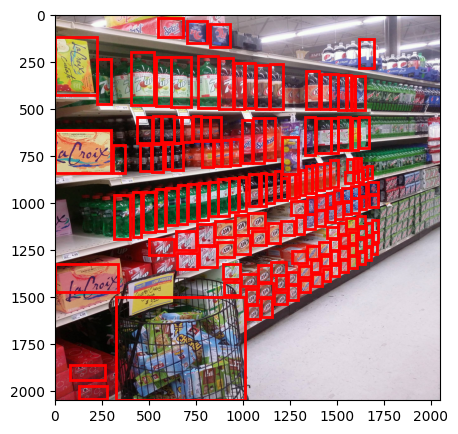

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


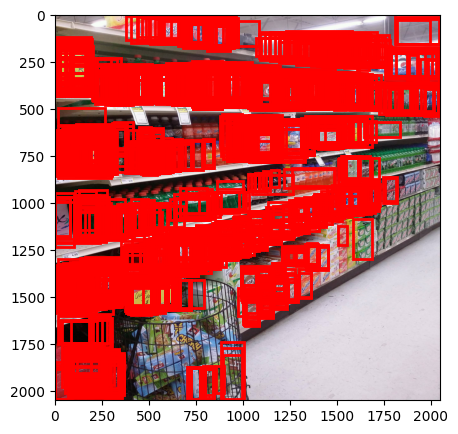

In [ ]:
for x,y in prediction.items():
  prediction[x] = y.cpu()
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()